In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [35]:
import numpy as np
from GomokuBoard import GomokuBoard
from HeuristicPolicy import Move, StochasticMaxSampler, HeuristicGomokuPolicy, ThreatSearch
from Heuristics import Heuristics
from GomokuTools import GomokuTools as gt

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

## A sampler
This class allows to sample from the top n of an array of scores, 
with higher probability for the larger scores. With bias > 1.0,
the sampler has an even higher bias toward the larger scores.


In [5]:
sample = np.random.randint(0, 100, [8,8])/20.0
enumerated = list(np.ndenumerate(sample))
sampler = StochasticMaxSampler(enumerated, 10, bias=5)
sampler.choices

[(0.5279933303660529, (7, 7), 0.47200666963394716, 4.95),
 (0.30503316696029864, (2, 3), 0.2229601634057542, 4.8),
 (0.19971424317374892, (7, 4), 0.10531892378654974, 4.65),
 (0.13583508684926854, (6, 3), 0.0638791563244804, 4.55),
 (0.07195593052478816, (5, 7), 0.0638791563244804, 4.55),
 (0.03321126369741455, (2, 6), 0.03874466682737361, 4.45),
 (0.022110730798622122, (4, 6), 0.011100532898792422, 4.2),
 (0.013465627084532682, (2, 0), 0.008645103714089438, 4.15),
 (0.006732813542266341, (0, 4), 0.006732813542266341, 4.1),
 (0.0, (0, 3), 0.006732813542266341, 4.1)]

In [6]:
print([sampler.draw() for i in range(10)])

[(6, 3), (5, 7), (7, 7), (7, 7), (7, 7), (7, 7), (7, 7), (2, 3), (7, 7), (7, 7)]


## Use a policy to play a bit

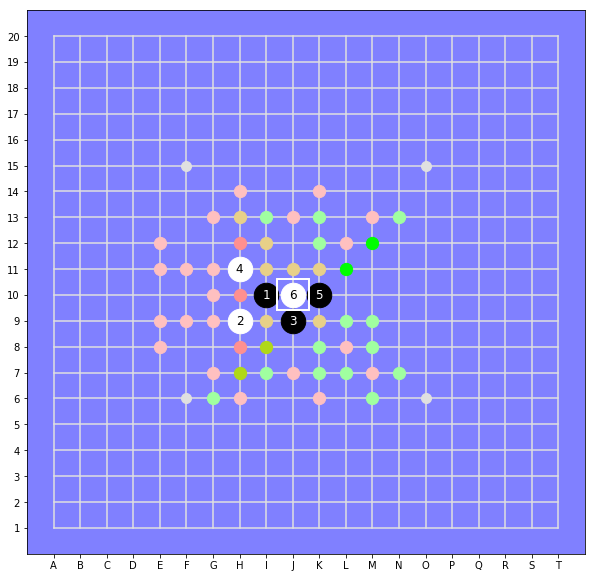

In [40]:
h = Heuristics(kappa=3.0)
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(board, style = 2, ts=ThreatSearch(5,3))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10)
board.display('current');

[(7, 9), (9, 7), (9, 11), (8, 10), (9, 12), (9, 13), (11, 12)]
CPU times: user 1.67 s, sys: 136 ms, total: 1.81 s
Wall time: 1.81 s
Pursuing winning threat sequence: (G, 9)
Value after the move: -4.259378814060682


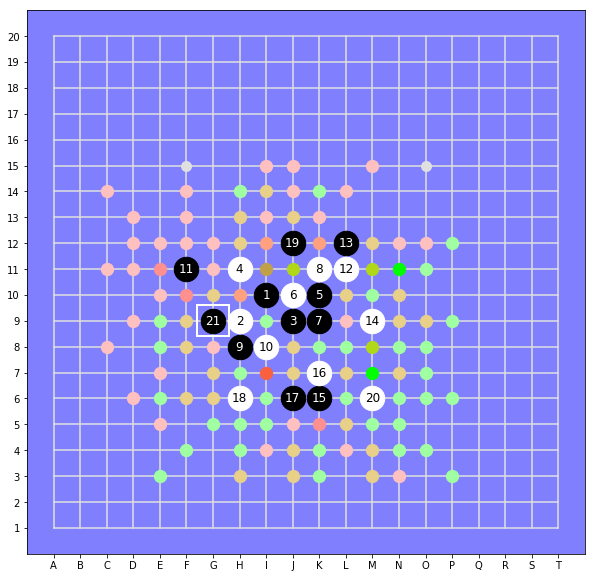

In [70]:
%time move = p.suggest(bias=.2, topn=5)
print(move)
if move.status == 0:
    board.set(move.x, move.y) 
    print("Value after the move: %s" % board.get_value())
else:
    print("GAME OVER!")
board.display('current')

In [52]:
board.set(G,8)

In [58]:
board.undo().undo()#.undo().undo().undo().undo().undo().undo()

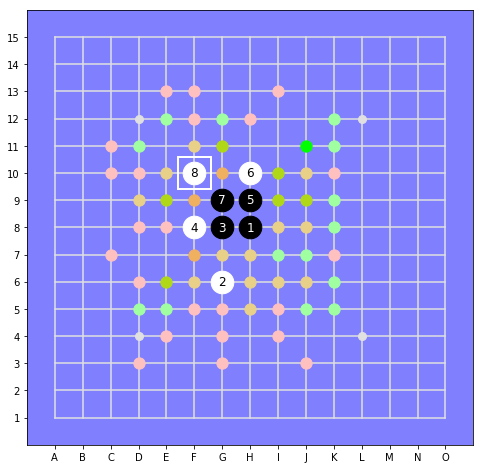

In [11]:
board.display("current")

In [145]:
p.suggest()

Defending Win-in-2: (J, 11)

In [147]:
board.getnh(J,11)

|                 |
|                 |
|                 |
|                 |
|        *        |
|      x          |
|    x            |
|  x              |
|                 |

In [138]:
board.current_color

0

In [148]:
rc = gt.b2m((J,11),15)

In [150]:
color = BLACK
options=[]
for direction in ['e', 'ne', 'n', 'nw']:
    step = np.array(gt.dirs()[direction][1])
    for w in [-4,-3,-2,-1,1,2,3,4]:
        r, c = rc+w*step
        if r >= 0 and r < 15 and c >= 0 and c < 15:
            x,y = gt.m2b((r,c), 15)
            if (x,y) not in board.stones:
                    board.set(x,y)
                    board.compute_scores(color)
                    s=board.get_score(color, J,11)
                    board.undo()
                    board.compute_scores(color)
                    if s < 7:
                        options.append((x,y))
options


[(6, 7), (11, 12)]

In [182]:
l = [list(zip(options, np.zeros(len(options))))[0]]
sampler = StochasticMaxSampler(l, len(options))

In [197]:
sampler.draw()

(6, 7)

In [184]:
color = BLACK
print(board.get_score(0,E,11))
for move in options:
    print(move, s)

4.999999999999999
(6, 7) 7.0
(11, 12) 7.0


In [32]:
rc + step * 3

array([4, 7])